# Named Entity Recognition

## Introduction

Named Entity Recognition (NER) is a crucial task in Natural Language Processing (NLP) that involves identifying and classifying entities in text into predefined categories such as persons, organizations, locations, etc. In this project, we will develop a NER pipeline using Conditional Random Fields (CRFs) with the CoNLL-2003 dataset.

This notebook will guide you through the following steps:
1. Importing necessary libraries
2. Loading and preparing the dataset
3. Extracting features for CRF
4. Training the CRF model
5. Evaluating the model with classification reports and confusion matrices
6. Visualizing the results



##  Import Libraries

In [1]:
# Import necessary libraries
import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from collections import defaultdict
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Ensure the necessary NLTK data packages are downloaded
nltk.download('averaged_perceptron_tagger')

/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/omar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading and Preparing the Dataset  
with Convert the Dataset to the Required Format which is `IOB format (Inside-Outside-Beginning)` which is a common tagging format used for annotating sequences in Named Entity Recognition (NER)

In [2]:
# Load the CoNLL-2003 dataset from Hugging Face
dataset = load_dataset('conll2003')

# Split the dataset into training, validation, and test sets
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

# Get the NER tags' and POS tags' label names
ner_label_names = dataset['train'].features['ner_tags'].feature.names
pos_label_names = dataset['train'].features['pos_tags'].feature.names

# Function to convert dataset to the required IOB format
def convert_to_iob_sents(dataset):
    """
    Convert the dataset into a list of sentences, each represented as a list of (token, POS, NER) tuples.
    
    Args:
    dataset (datasets.Dataset): The dataset containing tokens, POS tags, and NER tags.
    
    Returns:
    list: A list of sentences, where each sentence is a list of tuples (token, POS, NER).
    """
    sentences = []  

    # Iterate over each example in the dataset
    for example in dataset:
        tokens = example['tokens']  # Extract tokens from the example
        pos_tags = example['pos_tags']  # Extract POS tags from the example
        ner_tags = example['ner_tags']  # Extract NER tags from the example
        
        sentence = []  

        for token, pos, ner in zip(tokens, pos_tags, ner_tags):
            # Convert POS and NER tag indices to their respective string labels
            sentence.append((token, pos_label_names[pos], ner_label_names[ner]))

        sentences.append(sentence)  

    return sentences 

# Convert the datasets
train_sents = convert_to_iob_sents(train_data)
valid_sents = convert_to_iob_sents(valid_data)
test_sents = convert_to_iob_sents(test_data)

# Debug: Print the first sentence in the converted training data
print("First sentence in training data after conversion:")
print(train_sents[0])


First sentence in training data after conversion:
[('EU', 'NNP', 'B-ORG'), ('rejects', 'VBZ', 'O'), ('German', 'JJ', 'B-MISC'), ('call', 'NN', 'O'), ('to', 'TO', 'O'), ('boycott', 'VB', 'O'), ('British', 'JJ', 'B-MISC'), ('lamb', 'NN', 'O'), ('.', '.', 'O')]


In [3]:
df_train_sentences = pd.DataFrame(train_data)
df_train_sentences.head(5)

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


## Extracting features From Data

### Calculate Word Frequencies

In [4]:
# Calculate word frequencies in the training corpus
word_freq = defaultdict(int)  

for sent in train_sents:  # Iterate over each sentence in the training data
    for token, _, _ in sent:  # Iterate over each token in the sentence
        word_freq[token.lower()] += 1  # Increment the count of the token (lowercased) in the defaultdict

# Convert defaultdict to a regular dictionary
word_freq = dict(word_freq)  # Convert the defaultdict to a regular dictionary


### Feature Extraction Functions

In [5]:
# Function to determine word shape
def word_shape(word):
    """
    Determine the shape of a word based on its character composition.
    
    Args:
    word (str): The input word to analyze.
    
    Returns:
    str: A string representing the shape of the word.
         - 'X' for uppercase letters
         - 'x' for lowercase letters
         - 'd' for digits
         - The original character for non-alphanumeric characters
    """
    shape = []
    for char in word:
        if char.isupper():
            shape.append('X')
        elif char.islower():
            shape.append('x')
        elif char.isdigit():
            shape.append('d')
        else:
            shape.append(char)
    return ''.join(shape)

# Function to extract features from a single token
def token2features(sent, i):
    """
    Extract features from a single token in a sentence for use in CRF model.
    
    Args:
    sent (list): A sentence represented as a list of tuples, where each tuple contains:
                 - The token (word)
                 - The part-of-speech (POS) tag
                 - The named entity (NER) tag
    i (int): The index of the token in the sentence.
    
    Returns:
    dict: A dictionary of features for the given token.
    """
    word = sent[i][0]
    postag = sent[i][1]
    
    # Basic features of the current word
    features = {
        'bias': 1.0,  # Bias feature to help with model calibration
        'word.lower()': word.lower(),  # Lowercase form of the word
        'word[-3:]': word[-3:],  # Last three characters of the word (suffix)
        'word[:3]': word[:3],  # First three characters of the word (prefix)
        'word.isupper()': word.isupper(),  # Is the word in uppercase?
        'word.istitle()': word.istitle(),  # Is the word title-cased (capitalized)?
        'word.isdigit()': word.isdigit(),  # Is the word a digit?
        'postag': postag,  # Part-of-speech tag
        'postag[:2]': postag[:2],  # First two characters of the POS tag
        'word_shape': word_shape(word),  # Shape of the word
        'word_freq': word_freq.get(word.lower(), 0)  # Frequency of the word in the training corpus
    }
    
    # Features for the previous word (if not at the beginning of the sentence)
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word': word1,
            '-1:word.lower()': word1.lower(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:word_shape': word_shape(word1),
            '-1:word_freq': word_freq.get(word1.lower(), 0)
        })
    else:
        features['BOS'] = True  # Beginning of Sentence (BOS) feature
    
    # Features for the next word (if not at the end of the sentence)
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word': word1,
            '+1:word.lower()': word1.lower(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:word_shape': word_shape(word1),
            '+1:word_freq': word_freq.get(word1.lower(), 0)
        })
    else:
        features['EOS'] = True  # End of Sentence (EOS) feature

    return features

# Function to convert a sentence into features
def sent2features(sent):
    """
    Convert a sentence into a list of feature dictionaries for each token.
    
    Args:
    sent (list): A sentence represented as a list of tuples (token, POS, NER).
    
    Returns:
    list: A list of feature dictionaries for each token in the sentence.
    """
    return [token2features(sent, i) for i in range(len(sent))]

# Function to extract labels from a sentence
def sent2labels(sent):
    """
    Extract labels (NER tags) from a sentence.
    
    Args:
    sent (list): A sentence represented as a list of tuples (token, POS, NER).
    
    Returns:
    list: A list of NER tags for each token in the sentence.
    """
    return [label for token, postag, label in sent]

## Prepare Data for Training and Testing

In [6]:
# Convert sentences to features and labels
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_valid = [sent2features(s) for s in valid_sents]
y_valid = [sent2labels(s) for s in valid_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

#Check the structure of a single feature set and label set
print("Structure of a single feature set:")
print(X_train[0])
print("Structure of a single label set:")
print(y_train[0])

Structure of a single feature set:
[{'bias': 1.0, 'word.lower()': 'eu', 'word[-3:]': 'EU', 'word[:3]': 'EU', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'NNP', 'postag[:2]': 'NN', 'word_shape': 'XX', 'word_freq': 24, 'BOS': True, '+1:word': 'rejects', '+1:word.lower()': 'rejects', '+1:postag': 'VBZ', '+1:postag[:2]': 'VB', '+1:word_shape': 'xxxxxxx', '+1:word_freq': 1}, {'bias': 1.0, 'word.lower()': 'rejects', 'word[-3:]': 'cts', 'word[:3]': 'rej', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'VBZ', 'postag[:2]': 'VB', 'word_shape': 'xxxxxxx', 'word_freq': 1, '-1:word': 'EU', '-1:word.lower()': 'eu', '-1:postag': 'NNP', '-1:postag[:2]': 'NN', '-1:word_shape': 'XX', '-1:word_freq': 24, '+1:word': 'German', '+1:word.lower()': 'german', '+1:postag': 'JJ', '+1:postag[:2]': 'JJ', '+1:word_shape': 'Xxxxxx', '+1:word_freq': 101}, {'bias': 1.0, 'word.lower()': 'german', 'word[-3:]': 'man', 'word[:3]': 'Ger', 'word.

## Train the CRF Model

In [7]:
# Initialize the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # Coefficient for L1 penalty
    c2=0.1,  # Coefficient for L2 penalty
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model
crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## Make Predictions and Evaluate the Model


In [8]:
import random

# Predict on the test set
y_pred = crf.predict(X_test)

# Randomly select an example sentence from the test set
example_idx = random.randint(0, len(X_test) - 1)
example_sentence = test_sents[example_idx]
true_tags = y_test[example_idx]
predicted_tags = y_pred[example_idx]

# Display the results as a DataFrame
def display_prediction_as_dataframe(tokens, true_tags, pred_tags):
    data = {'Token': [token[0] for token in tokens], 'True Tag': true_tags, 'Predicted Tag': pred_tags}
    df = pd.DataFrame(data)
    return df

df = display_prediction_as_dataframe(example_sentence, true_tags, predicted_tags)
df

,Token,True Tag,Predicted Tag
0,*,O,O
1,The,O,O
2,UDMR,B-ORG,B-ORG
3,wants,O,O
4,to,O,O
5,contribute,O,O
6,to,O,O
7,social,O,O
8,reform,O,O
9,and,O,O


## Show Results

### Create Classification Report Plots

In [9]:
# Make predictions on the validation set
y_valid_pred = crf.predict(X_valid)

# Make predictions on the test set
y_test_pred = crf.predict(X_test)


In [10]:
crf.classes_

['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']

In [11]:
# Make predictions on the validation set
y_valid_pred = crf.predict(X_valid)

# Make predictions on the test set
y_test_pred = crf.predict(X_test)

# Generate classification reports
report_valid = metrics.flat_classification_report(y_valid, y_valid_pred, labels=list(crf.classes_), output_dict=True)
report_test = metrics.flat_classification_report(y_test, y_test_pred, labels=list(crf.classes_), output_dict=True)

# Function to extract metrics from classification report dictionary
def extract_metrics(report_dict):
    """
    Extract metrics from the classification report dictionary.

    Args:
    report_dict (dict): The classification report as a dictionary.

    Returns:
    tuple: A tuple containing:
           - labels (list): A list of label names.
           - metrics_dict (dict): A dictionary with metrics (precision, recall, f1-score, support) for each label.
    """
    labels = []
    metrics_dict = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    for label, metrics in report_dict.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        labels.append(label)
        metrics_dict['precision'].append(metrics['precision'])
        metrics_dict['recall'].append(metrics['recall'])
        metrics_dict['f1-score'].append(metrics['f1-score'])
        metrics_dict['support'].append(metrics['support'])
    return labels, metrics_dict

# Extract metrics for validation and test sets
labels_valid, metrics_valid = extract_metrics(report_valid)
labels_test, metrics_test = extract_metrics(report_test)

In [12]:
labels_valid

['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']

### plot metrics For Data

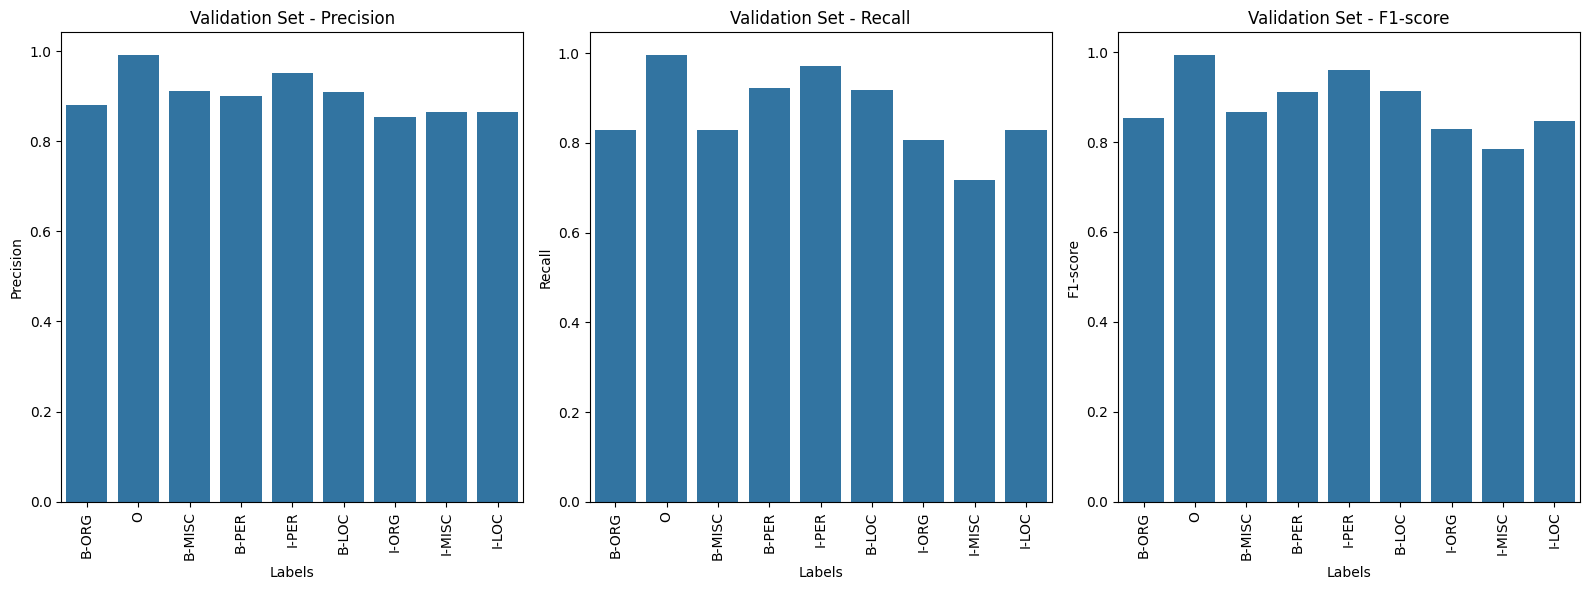

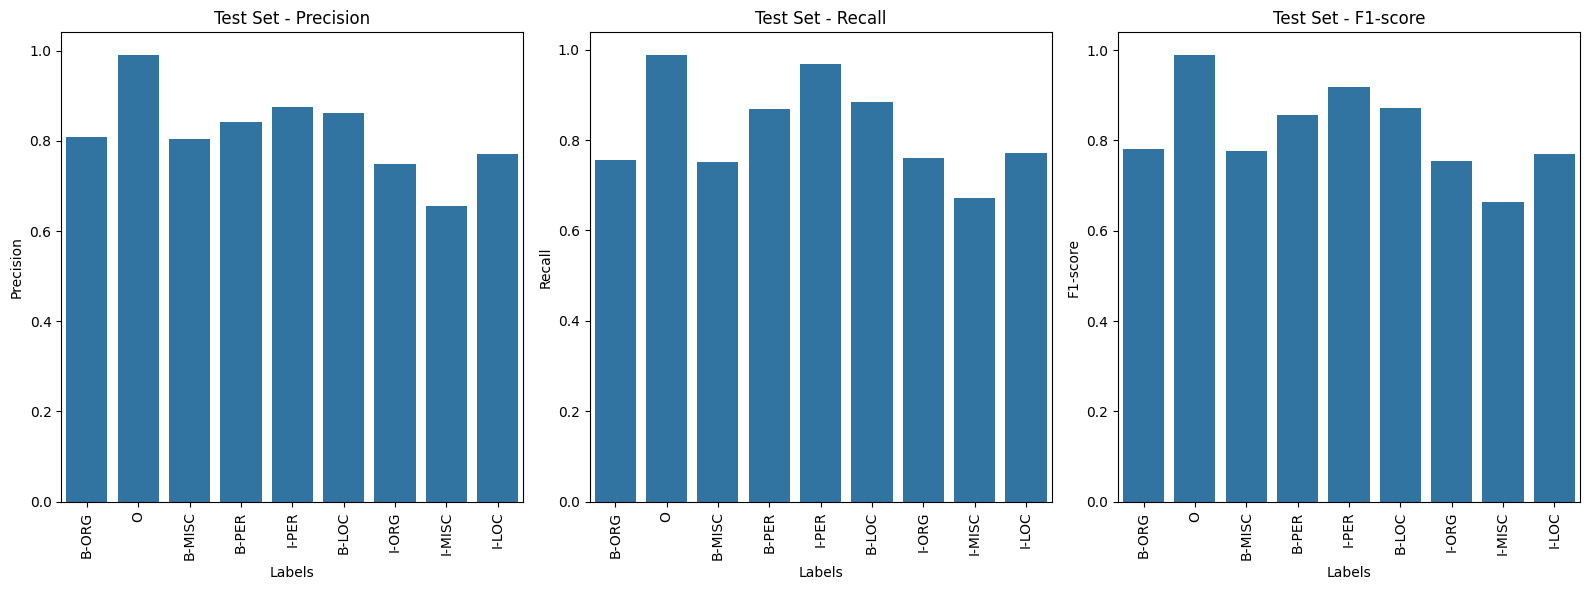

In [15]:
import numpy as np

# Plotting function for metrics
def plot_metrics(labels, metrics, title):
    """
    Plot precision, recall, and F1-score for each label.
    
    Args:
    labels (list): List of label names.
    metrics (dict): Dictionary containing precision, recall, and f1-score for each label.
    title (str): Title of the plot.
    """
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))

    sns.barplot(x=labels, y=metrics['precision'], ax=ax[0])
    ax[0].set_title(f'{title} - Precision')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlabel('Labels')
    ax[0].xaxis.set_major_locator(plt.FixedLocator(range(len(labels))))
    ax[0].set_xticklabels(labels, rotation=90)

    sns.barplot(x=labels, y=metrics['recall'], ax=ax[1])
    ax[1].set_title(f'{title} - Recall')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Labels')
    ax[1].xaxis.set_major_locator(plt.FixedLocator(range(len(labels))))
    ax[1].set_xticklabels(labels, rotation=90)

    sns.barplot(x=labels, y=metrics['f1-score'], ax=ax[2])
    ax[2].set_title(f'{title} - F1-score')
    ax[2].set_ylabel('F1-score')
    ax[2].set_xlabel('Labels')
    ax[2].xaxis.set_major_locator(plt.FixedLocator(range(len(labels))))
    ax[2].set_xticklabels(labels, rotation=90)

    plt.tight_layout()
    plt.show()

# Plot metrics for validation and test sets
plot_metrics(labels_valid, metrics_valid, 'Validation Set')
plot_metrics(labels_test, metrics_test, 'Test Set')

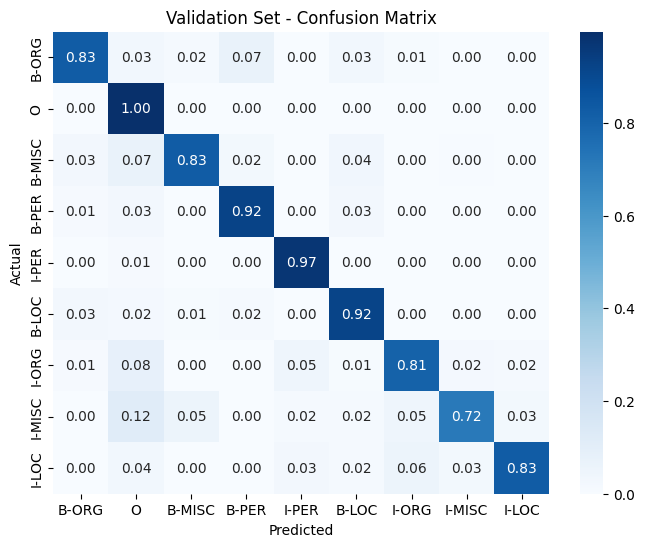

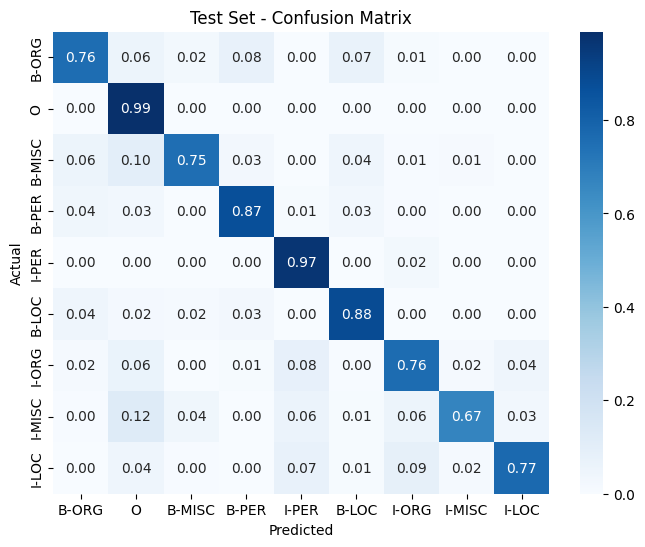

In [16]:
# Confusion matrix function with row normalization
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    Plot confusion matrix for actual vs predicted labels.
    
    Args:
    y_true (list): True labels.
    y_pred (list): Predicted labels.
    labels (list): List of label names.
    title (str): Title of the plot.
    """
    # Flatten the nested lists
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Use the same labels for both validation and test sets
common_labels = ['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']

# Plot confusion matrix for validation and test sets
plot_confusion_matrix(y_valid, y_valid_pred, labels=common_labels, title='Validation Set')
plot_confusion_matrix(y_test, y_test_pred, labels=common_labels, title='Test Set')

### Display Overall Metrics in a Table

In [21]:
report_test

{'B-ORG': {'precision': 0.8091553836234687,
  'recall': 0.7555689343768814,
  'f1-score': 0.7814445828144458,
  'support': 1661.0},
 'O': {'precision': 0.9909521194529431,
  'recall': 0.9888317720428985,
  'f1-score': 0.989890810302492,
  'support': 38323.0},
 'B-MISC': {'precision': 0.8033536585365854,
  'recall': 0.7507122507122507,
  'f1-score': 0.7761413843888071,
  'support': 702.0},
 'B-PER': {'precision': 0.8414123279473369,
  'recall': 0.8695114409400123,
  'f1-score': 0.8552311435523114,
  'support': 1617.0},
 'I-PER': {'precision': 0.87548942834769,
  'recall': 0.967128027681661,
  'f1-score': 0.9190300041101521,
  'support': 1156.0},
 'B-LOC': {'precision': 0.8606413994169096,
  'recall': 0.8848920863309353,
  'f1-score': 0.8725982855453739,
  'support': 1668.0},
 'I-ORG': {'precision': 0.7494089834515366,
  'recall': 0.7592814371257485,
  'f1-score': 0.7543129089827484,
  'support': 835.0},
 'I-MISC': {'precision': 0.6561085972850679,
  'recall': 0.6712962962962963,
  'f1-s

In [17]:
# Function to calculate overall precision, recall, and F1-score
def calculate_overall_metrics(report_dict):
    """
    Calculate overall precision, recall, and F1-score from the classification report dictionary.

    Args:
    report_dict (dict): The classification report as a dictionary.

    Returns:
    dict: Dictionary containing overall precision, recall, and F1-score.
    """
    overall_metrics = {
        'accuracy': report_dict['accuracy'] * 100,  # Convert to percentage
        'precision': report_dict['weighted avg']['precision'] * 100,
        'recall': report_dict['weighted avg']['recall'] * 100,
        'f1-score': report_dict['weighted avg']['f1-score'] * 100
    }
    return overall_metrics

# Calculate overall metrics for validation and test sets
overall_metrics_valid = calculate_overall_metrics(report_valid)
overall_metrics_test = calculate_overall_metrics(report_test)

# Display overall metrics in a DataFrame
def display_overall_metrics(metrics_valid, metrics_test):
    """
    Display overall precision, recall, and F1-score for validation and test sets.

    Args:
    metrics_valid (dict): Overall metrics for the validation set.
    metrics_test (dict): Overall metrics for the test set.
    """
    data = {
        'Set': ['Validation', 'Test'],
        'Accuracy': [metrics_valid['accuracy'], metrics_test['accuracy']],
        'Precision': [metrics_valid['precision'], metrics_test['precision']],
        'Recall': [metrics_valid['recall'], metrics_test['recall']],
        'F1-Score': [metrics_valid['f1-score'], metrics_test['f1-score']]
    }
    df = pd.DataFrame(data)
    df['Accuracy'] = df['Accuracy'].apply(lambda x: f"{x :.2f}%")
    df['Precision'] = df['Precision'].apply(lambda x: f"{x:.2f}%")
    df['Recall'] = df['Recall'].apply(lambda x: f"{x:.2f}%")
    df['F1-Score'] = df['F1-Score'].apply(lambda x: f"{x:.2f}%")
    display(df)

display_overall_metrics(overall_metrics_valid, overall_metrics_test)

,Set,Accuracy,Precision,Recall,F1-Score
0,Validation,97.75%,97.70%,97.75%,97.71%
1,Test,96.16%,96.17%,96.16%,96.16%
